# Lab 4: Human Pose Estimation with MediaPipe

Demonstrates pose estimation, CSV export, skeleton visualization, and head pose estimation.


## Setup and Imports


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# Import our custom modules
from mediapipe_pose_estimation import MediaPipePoseEstimator
from csv_skeleton_visualizer import SkeletonVisualizer

# Set up paths
DATA_DIR = Path('data')
OUTPUT_DIR = Path('output')
OUTPUT_DIR.mkdir(exist_ok=True)

## RB Dataset Overview

RB dataset for sports exercise recognition:
- 60 recordings from 60 students
- 17 classes (class `-001` = no action)
- Train/Test: odd frames = train, even frames = test


In [ ]:
# Examine RB dataset structure and labels
label_path = DATA_DIR / 'label' / '001_d26arrd1.csv'

if label_path.exists():
    labels_df = pd.read_csv(label_path, header=None, names=['frame', 'class1', 'class2'])
    
    print("RB Dataset Label File Overview:")
    print(f"Total frames: {len(labels_df)}")
    print(f"\nFirst 20 frames:")
    print(labels_df.head(20))
    print(f"\nUnique classes in column 1: {sorted(labels_df['class1'].unique())}")
    print(f"\nUnique classes in column 2: {sorted(labels_df['class2'].unique())}")
    
    # Demonstrate train/test split: odd frames = train, even frames = test
    train_frames = labels_df[labels_df['frame'] % 2 == 1]
    test_frames = labels_df[labels_df['frame'] % 2 == 0]
    
    print(f"\nTrain/Test Split:")
    print(f"  Train frames (odd): {len(train_frames)} ({len(train_frames)/len(labels_df)*100:.1f}%)")
    print(f"  Test frames (even): {len(test_frames)} ({len(test_frames)/len(labels_df)*100:.1f}%)")
else:
    print(f"Label file not found: {label_path}")
    print("This is expected if the dataset hasn't been fully downloaded.")

RB Dataset Label File Overview:
Total frames: 8595

First 20 frames:
    frame  class1  class2
0       1      -1      -1
1       2      -1      -1
2       3      -1      -1
3       4      -1      -1
4       5      -1      -1
5       6      -1      -1
6       7      -1      -1
7       8      -1      -1
8       9      -1      -1
9      10      -1      -1
10     11      -1      -1
11     12      -1      -1
12     13      -1      -1
13     14      -1      -1
14     15      -1      -1
15     16      -1      -1
16     17      -1      -1
17     18      -1      -1
18     19      -1      -1
19     20      -1      -1

Unique classes in column 1: [np.int64(-1)]

Unique classes in column 2: [np.int64(-1), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16)]

Train/Test Split:
  Train frames (odd): 4298 (50.0%)
  Test frames (even): 4297 (50.0%)


## MediaPipe Pose Estimation

Extract 33 body landmarks using MediaPipe Pose.


In [ ]:
# Initialize MediaPipe Pose estimator
pose_estimator = MediaPipePoseEstimator(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("MediaPipe Pose Estimator initialized")
print(f"Landmarks available: {len(pose_estimator.landmark_names)}")
print(f"First 10 landmarks: {pose_estimator.landmark_names[:10]}")

MediaPipe Pose Estimator initialized
Landmarks available: 33
First 10 landmarks: ['NOSE', 'LEFT_EYE_INNER', 'LEFT_EYE', 'LEFT_EYE_OUTER', 'RIGHT_EYE_INNER', 'RIGHT_EYE', 'RIGHT_EYE_OUTER', 'LEFT_EAR', 'RIGHT_EAR', 'MOUTH_LEFT']


I0000 00:00:1762128160.443849 7459381 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Process a Single Frame


I0000 00:00:1762128160.464656 7459381 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
W0000 00:00:1762128160.510767 7459530 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762128160.515897 7459528 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762128160.524184 7459543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762128160.529401 7459541 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/mateu/Education/sem9/cv/lab4/.venv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is 

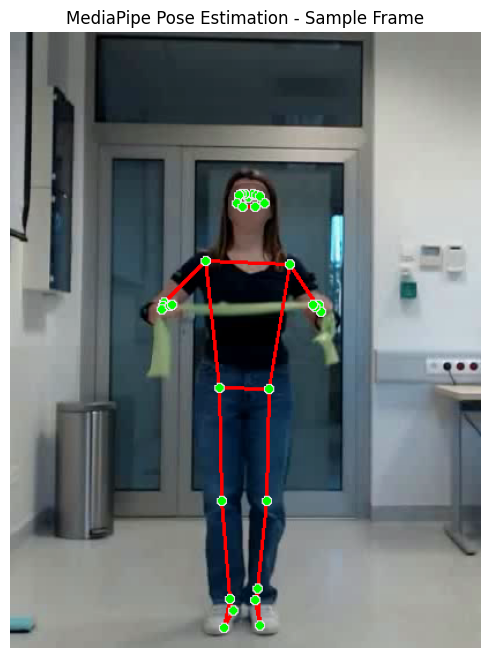

Frame shape: (534, 408, 3)
Pose detected: True
Number of landmarks detected: 33


In [ ]:
import mediapipe as mp

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Try to load a frame from video
video_path = DATA_DIR / 'anon' / '001_d26arrd1.mp4'

if video_path.exists():
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()
    
    if ret:
        # Convert BGR to RGB
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        rgb_frame.flags.writeable = False
        
        # Process with MediaPipe
        results = pose.process(rgb_frame)
        
        # Convert back and draw
        rgb_frame.flags.writeable = True
        frame_with_pose = cv2.cvtColor(rgb_frame, cv2.COLOR_RGB2BGR)
        
        if results.pose_landmarks:
            mp_drawing.draw_landmarks(
                frame_with_pose,
                results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2)
            )
        
        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(frame_with_pose, cv2.COLOR_BGR2RGB))
        plt.title("MediaPipe Pose Estimation - Sample Frame")
        plt.axis('off')
        plt.show()
        
        print(f"Frame shape: {frame.shape}")
        print(f"Pose detected: {results.pose_landmarks is not None}")
        if results.pose_landmarks:
            print(f"Number of landmarks detected: {len(results.pose_landmarks.landmark)}")
else:
    print(f"Video not found: {video_path}")

### Process Video and Save to CSV


In [ ]:
video_path = DATA_DIR / 'anon' / '001_d26arrd1.mp4'
output_csv = OUTPUT_DIR / 'pose_estimation_output.csv'
output_video = OUTPUT_DIR / 'pose_visualized.mp4'

if video_path.exists():
    print(f"Processing video: {video_path}")
    num_frames = pose_estimator.process_video(
        str(video_path),
        str(output_csv),
        visualize=True,
        output_video_path=str(output_video)
    )
    print(f"\nProcessed {num_frames} frames")
    print(f"Results saved to: {output_csv}")
else:
    print(f"Video not found: {video_path}")

Processing video: data/anon/001_d26arrd1.mp4
Processing video: data/anon/001_d26arrd1.mp4
Video properties: 408x534 @ 30 fps
Processed 30 frames...
Processed 60 frames...
Processed 90 frames...
Processed 120 frames...
Processed 150 frames...
Processed 180 frames...
Processed 210 frames...
Processed 240 frames...
Processed 270 frames...
Processed 300 frames...
Processed 330 frames...
Processed 360 frames...
Processed 390 frames...
Processed 420 frames...
Processed 450 frames...
Processed 480 frames...
Processed 510 frames...
Processed 540 frames...
Processed 570 frames...
Processed 600 frames...
Processed 630 frames...
Processed 660 frames...
Processed 690 frames...
Processed 720 frames...
Processed 750 frames...
Processed 780 frames...
Processed 810 frames...
Processed 840 frames...
Processed 870 frames...
Processed 900 frames...
Processed 930 frames...
Processed 960 frames...
Processed 990 frames...
Processed 1020 frames...
Processed 1050 frames...
Processed 1080 frames...
Processed 1

## CSV Skeleton Visualization


In [ ]:
# Initialize visualizer
visualizer = SkeletonVisualizer()

# Load skeleton data from existing CSV
csv_path = DATA_DIR / 'mp_pose_csv' / '001_Subject_d26arrd1.csv'

if csv_path.exists():
    skeletons = visualizer.load_csv(str(csv_path))
    print(f"Loaded skeletons for {len(skeletons)} frames")
    
    # Show information about first frame
    first_frame = min(skeletons.keys())
    print(f"\nFirst frame ({first_frame}) has {len(skeletons[first_frame])} landmarks")
    print(f"Sample landmarks from frame {first_frame}:")
    for i, (landmark, x, y, z) in enumerate(skeletons[first_frame][:5]):
        print(f"  {i+1}. {landmark}: ({x:.4f}, {y:.4f}, {z:.4f})")
else:
    print(f"CSV file not found: {csv_path}")

Loaded 8595 frames from data/mp_pose_csv/001_Subject_d26arrd1.csv
Loaded skeletons for 8595 frames

First frame (1) has 33 landmarks
Sample landmarks from frame 1:
  1. NOSE: (0.4157, 0.3611, -0.1440)
  2. LEFT_EYE_INNER: (0.4223, 0.3510, -0.1199)
  3. LEFT_EYE: (0.4260, 0.3516, -0.1199)
  4. LEFT_EYE_OUTER: (0.4290, 0.3520, -0.1199)
  5. RIGHT_EYE_INNER: (0.4089, 0.3494, -0.1211)


### Visualize Specific Frames


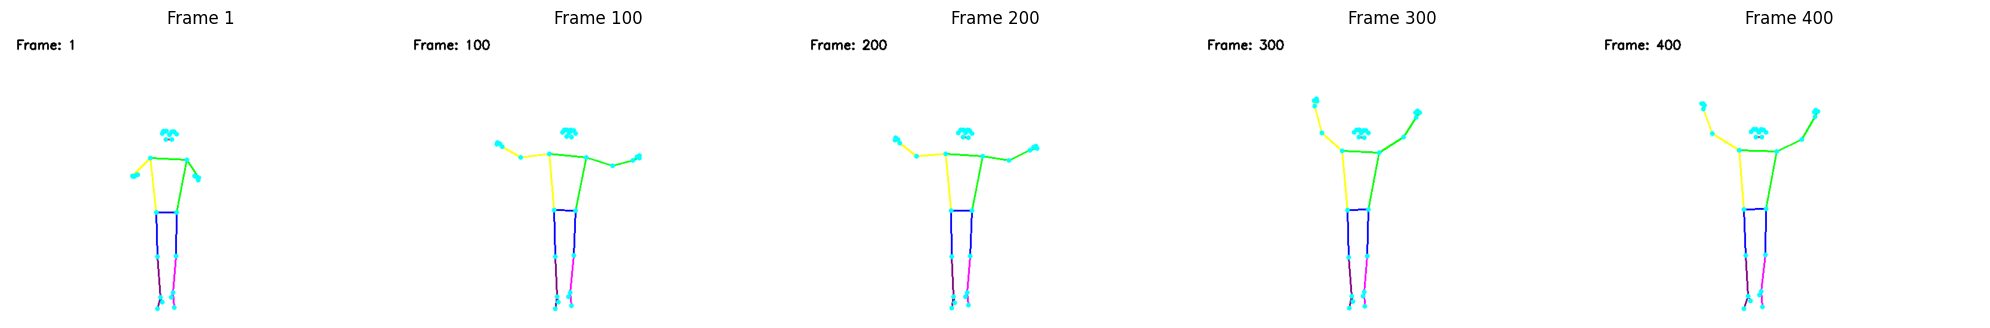

In [ ]:
# Visualize a few sample frames
if csv_path.exists() and 'skeletons' in locals():
    sample_frames = [1, 100, 200, 300, 400]
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    for idx, frame_num in enumerate(sample_frames):
        if frame_num in skeletons:
            # Create visualization
            image = np.ones((480, 640, 3), dtype=np.uint8) * 255
            image = visualizer.draw_skeleton(image, skeletons[frame_num])
            
            # Add frame number
            cv2.putText(image, f'Frame: {frame_num}', (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
            
            axes[idx].imshow(image)
            axes[idx].set_title(f"Frame {frame_num}")
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f"Frame {frame_num}\nnot found", 
                         ha='center', va='center')
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("CSV file not available")

### Analyze Skeleton Data


In [ ]:
# Load CSV as pandas DataFrame for analysis
if csv_path.exists():
    df = pd.read_csv(csv_path)
    
    print("CSV Data Overview:")
    print(f"Total rows: {len(df)}")
    print(f"Total frames: {df['frame_number'].nunique()}")
    print(f"Unique landmarks: {df['landmark'].nunique()}")
    print(f"\nLandmark names:")
    print(df['landmark'].unique())
    
    # Show statistics for first frame
    frame_1 = df[df['frame_number'] == 1]
    print(f"\nFrame 1 statistics:")
    print(f"  X coordinates - Min: {frame_1['x'].min():.4f}, Max: {frame_1['x'].max():.4f}, Mean: {frame_1['x'].mean():.4f}")
    print(f"  Y coordinates - Min: {frame_1['y'].min():.4f}, Max: {frame_1['y'].max():.4f}, Mean: {frame_1['y'].mean():.4f}")
    print(f"  Z coordinates - Min: {frame_1['z'].min():.4f}, Max: {frame_1['z'].max():.4f}, Mean: {frame_1['z'].mean():.4f}")
    
    # Display first few rows
    print("\nFirst 10 rows:")
    print(df.head(10))
else:
    print("CSV file not available")

CSV Data Overview:
Total rows: 283635
Total frames: 8595
Unique landmarks: 33

Landmark names:
['NOSE' 'LEFT_EYE_INNER' 'LEFT_EYE' 'LEFT_EYE_OUTER' 'RIGHT_EYE_INNER'
 'RIGHT_EYE' 'RIGHT_EYE_OUTER' 'LEFT_EAR' 'RIGHT_EAR' 'MOUTH_LEFT'
 'MOUTH_RIGHT' 'LEFT_SHOULDER' 'RIGHT_SHOULDER' 'LEFT_ELBOW' 'RIGHT_ELBOW'
 'LEFT_WRIST' 'RIGHT_WRIST' 'LEFT_PINKY' 'RIGHT_PINKY' 'LEFT_INDEX'
 'RIGHT_INDEX' 'LEFT_THUMB' 'RIGHT_THUMB' 'LEFT_HIP' 'RIGHT_HIP'
 'LEFT_KNEE' 'RIGHT_KNEE' 'LEFT_ANKLE' 'RIGHT_ANKLE' 'LEFT_HEEL'
 'RIGHT_HEEL' 'LEFT_FOOT_INDEX' 'RIGHT_FOOT_INDEX']

Frame 1 statistics:
  X coordinates - Min: 0.3198, Max: 0.4932, Mean: 0.4109
  Y coordinates - Min: 0.3494, Max: 0.9677, Mean: 0.5570
  Z coordinates - Min: -0.4128, Max: 0.1456, Mean: -0.1074

First 10 rows:
   frame_number         landmark       x       y       z
0             1             NOSE  0.4157  0.3611 -0.1440
1             1   LEFT_EYE_INNER  0.4223  0.3510 -0.1199
2             1         LEFT_EYE  0.4260  0.3516 -0.1199
3   

### Visualize Skeleton Over Time


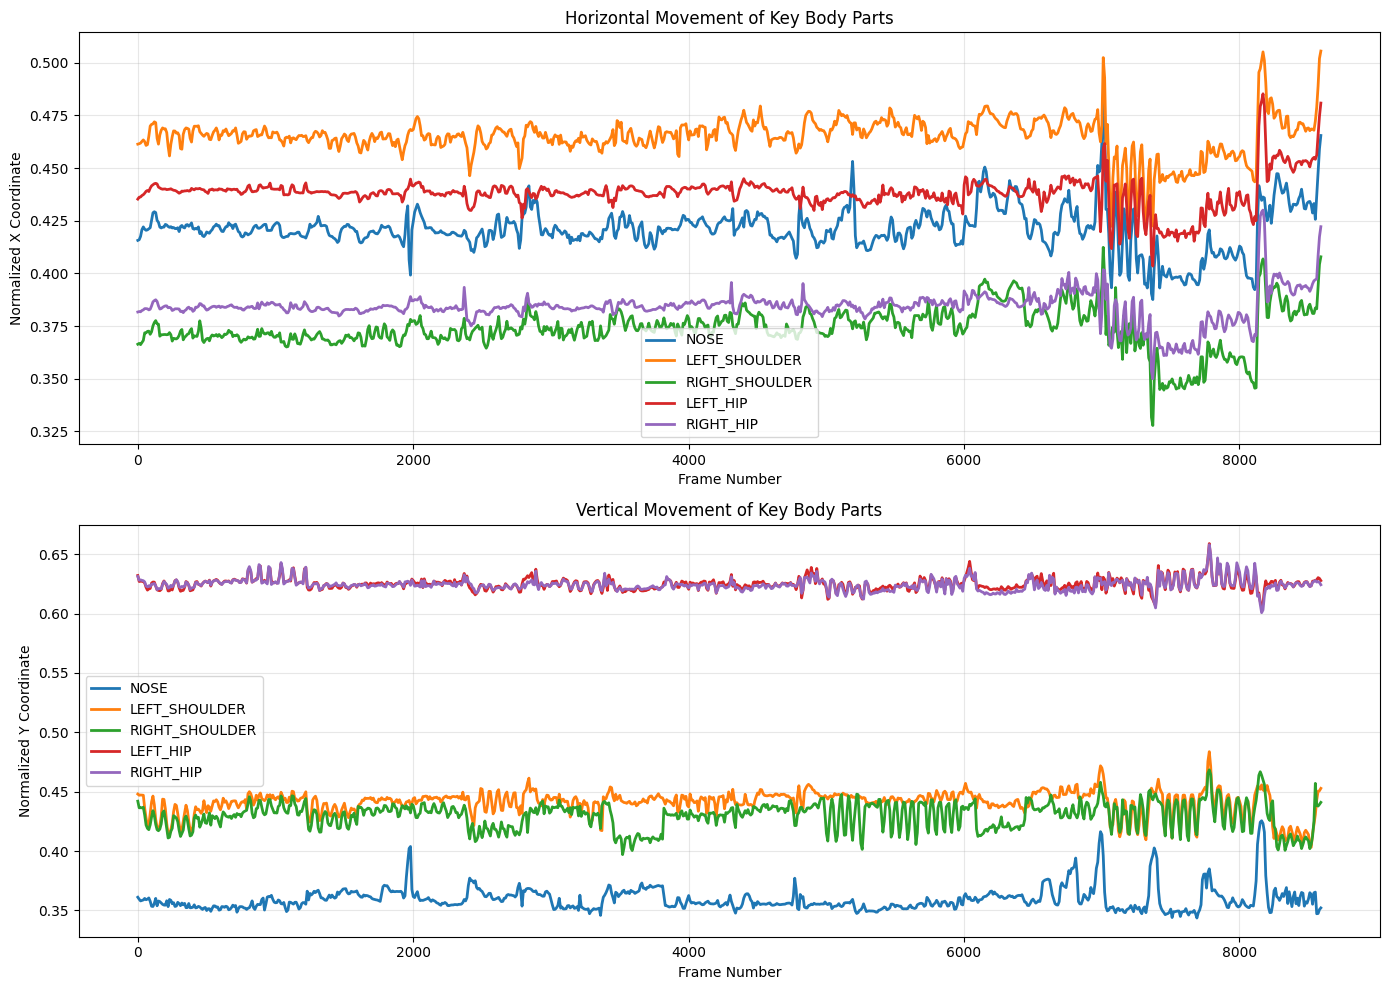

In [ ]:
if csv_path.exists() and 'skeletons' in locals():
    # Extract trajectory of key landmarks
    key_landmarks = ['NOSE', 'LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_HIP', 'RIGHT_HIP']
    
    trajectories = {lm: {'x': [], 'y': [], 'z': [], 'frames': []} 
                   for lm in key_landmarks}
    
    # Sample frames (every 10th frame for performance)
    sample_rate = 10
    for frame_num in sorted(skeletons.keys())[::sample_rate]:
        landmarks_dict = {name: (x, y, z) for name, x, y, z in skeletons[frame_num]}
        
        for lm in key_landmarks:
            if lm in landmarks_dict:
                x, y, z = landmarks_dict[lm]
                trajectories[lm]['x'].append(x)
                trajectories[lm]['y'].append(y)
                trajectories[lm]['z'].append(z)
                trajectories[lm]['frames'].append(frame_num)
    
    # Plot trajectories
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # X trajectory
    for lm in key_landmarks:
        if trajectories[lm]['frames']:
            axes[0].plot(trajectories[lm]['frames'], trajectories[lm]['x'], 
                       label=lm, linewidth=2)
    axes[0].set_xlabel('Frame Number')
    axes[0].set_ylabel('Normalized X Coordinate')
    axes[0].set_title('Horizontal Movement of Key Body Parts')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Y trajectory
    for lm in key_landmarks:
        if trajectories[lm]['frames']:
            axes[1].plot(trajectories[lm]['frames'], trajectories[lm]['y'], 
                       label=lm, linewidth=2)
    axes[1].set_xlabel('Frame Number')
    axes[1].set_ylabel('Normalized Y Coordinate')
    axes[1].set_title('Vertical Movement of Key Body Parts')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("CSV file not available")


## Head Pose Estimation

Using MediaPipe Face Mesh for head pose estimation.


I0000 00:00:1762128284.141657 7459381 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3 Pro
W0000 00:00:1762128284.143622 7462014 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1762128284.145291 7462015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/mateu/Education/sem9/cv/lab4/.venv/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


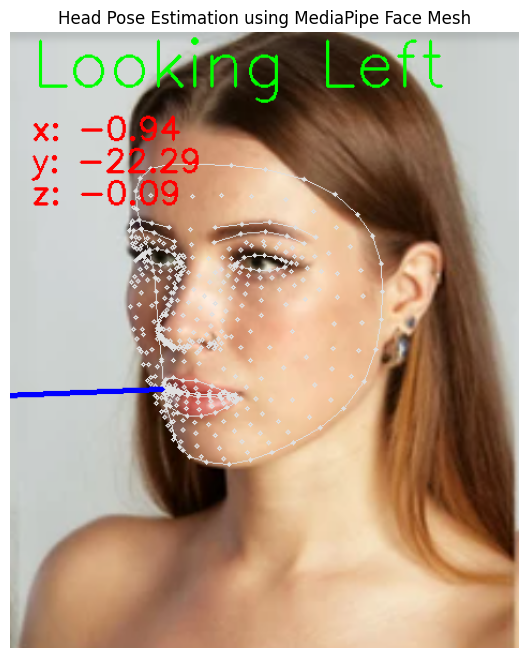

Head pose detected: True
Number of face landmarks: 468


In [10]:
# Head pose estimation using existing code pattern
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Try to load a test image or frame from video
test_image_path = Path('materials') / '02_head_pose.png'

if test_image_path.exists():
    image = cv2.imread(str(test_image_path))
    
    # Convert BGR to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_image.flags.writeable = False
    
    # Process with MediaPipe Face Mesh
    results = face_mesh.process(rgb_image)
    
    # Convert back
    rgb_image.flags.writeable = True
    output_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    
    img_h, img_w, img_c = output_image.shape
    
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # Draw face mesh
            mp_drawing.draw_landmarks(
                image=output_image,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec
            )
            
            # Extract key points for pose estimation
            key_points = [33, 263, 1, 61, 291, 199]
            face_2d = []
            face_3d = []
            
            for idx, lm in enumerate(face_landmarks.landmark):
                if idx in key_points:
                    x, y = int(lm.x * img_w), int(lm.y * img_h)
                    face_2d.append([x, y])
                    face_3d.append([x, y, lm.z])
            
            # Convert to numpy arrays
            face_2d = np.array(face_2d, dtype=np.float64)
            face_3d = np.array(face_3d, dtype=np.float64)
            
            # Camera matrix
            focal_length = 1 * img_w
            cam_matrix = np.array([
                [focal_length, 0, img_h / 2],
                [0, focal_length, img_w / 2],
                [0, 0, 1]
            ])
            
            # Distortion parameters
            dist_matrix = np.zeros((4, 1), dtype=np.float64)
            
            # Solve PnP
            success, rot_vec, trans_vec = cv2.solvePnP(
                face_3d, face_2d, cam_matrix, dist_matrix
            )
            
            # Get rotation matrix
            rmat, jac = cv2.Rodrigues(rot_vec)
            
            # Get angles
            angles, mtxR, mtxQ, Qx, Qy, Qz = cv2.RQDecomp3x3(rmat)
            
            x_angle = angles[0] * 360
            y_angle = angles[1] * 360
            z_angle = angles[2] * 360
            
            # Determine head pose direction
            if y_angle < -10:
                text = "Looking Left"
            elif y_angle > 10:
                text = "Looking Right"
            elif x_angle < -10:
                text = "Looking Down"
            elif x_angle > 10:
                text = "Looking Up"
            else:
                text = "Forward"
            
            # Draw nose direction
            nose_2d = (face_2d[2][0], face_2d[2][1])
            p1 = (int(nose_2d[0]), int(nose_2d[1]))
            p2 = (int(nose_2d[0] + y_angle * 10), int(nose_2d[1] - x_angle * 10))
            cv2.line(output_image, p1, p2, (255, 0, 0), 3)
            
            # Add text
            cv2.putText(output_image, text, (20, 50), 
                       cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 2)
            cv2.putText(output_image, f"x: {x_angle:.2f}", (20, 100), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.putText(output_image, f"y: {y_angle:.2f}", (20, 130), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2.putText(output_image, f"z: {z_angle:.2f}", (20, 160), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    # Display
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title("Head Pose Estimation using MediaPipe Face Mesh")
    plt.axis('off')
    plt.show()
    
    print(f"Head pose detected: {results.multi_face_landmarks is not None}")
    if results.multi_face_landmarks:
        print(f"Number of face landmarks: {len(results.multi_face_landmarks[0].landmark)}")
else:
    print(f"Test image not found: {test_image_path}")